# Lab 1: ETL and Clustering
> Your name: Melissa Benoit

## Part 1: Data gathering and cleaning

> In data science, to get data to actually work with, an ETL (Extract, Transform and Load) procedure is used. 

> **Extraction** means that data is collected from somewhere

> **Transform** means that the data is converted into a useable format. In this step, the data is also cleaned. Data cleaning consists of several operations such as the removal of bad data, removal of duplicate data and the resolution of missing values.

> In the **Load** step, the data is stored for future usage (such as a database).

> In this practicum we will focus on the two first steps, extracting and transforming data. Furthermore, we also will do data exploration. Later in this course you will see how machine learning can be applied to make predictions using data. To be able to do this, the data has to be understood. Hence, data exploration is required.

![ETL](http://uploads.webflow.com/54e3cc87305a0f0a0665f71f/5537351f5f1065d401cde83c_etl-elt-architecture.jpg)

> Two new libraries will be used to do these steps: *matplotlib* a python visualization library and *pandas* a data manipulation library





### The use case:
> [EVA](http://www.evavzw.be/) is a website of a vegetarian organization. On their website they have a [list of restaurants](http://www.evavzw.be/resto) from all over Belgium. We want to have this data to get insights into these restaurants. However, EVA does not have a public web API which we can query to access this information. Hence, we will use the [selenium](https://selenium-python.readthedocs.io/) webscraper to scrape the information from their site. Subsequently, we will analyse the collected data.

![ETL](https://pbs.twimg.com/profile_images/378800000338402401/9c164104f9e1d9f5c2eea49368973ce4.png)

> Fill in this notebook, "**#+++ your code here +++**" gives an indication where code is expected

### Installation

> Anaconda will have installed pandas and matplotlib. However, selenium will not be installed. 

> To search for a selenium package open a shell/prompt:

>    * anaconda search -t conda selenium

> or go to https://anaconda.org/ and search for selenium

> Install as follows (example package, this can be different for you):

>    * conda install -c bokeh selenium

> Additionally, selenium requires a chromedriver: https://sites.google.com/a/chromium.org/chromedriver/downloads

> Put this driver in the same folders as this notebook

* * *

### Pandas

In [1]:
import pandas as pd
import numpy as np

> Pandas enables us to use DataFrames. A DataFrame is a two-dimensional size-mutable, potentially heterogeneous tabular data structure with labeled axes (rows and columns).

In [2]:
#Generate a 2D array of random values. There are 10 rows and 4 columns
dummy_data = np.random.randint(0,100,size=(10, 4))

# The matching column headers for the 4 columns
matching_columns = ['A','B','C','D']

# Create a pandas DataFrame using the data and headers.
df = pd.DataFrame(dummy_data, columns=matching_columns)
df

,A,B,C,D
0,83,44,45,74
1,79,54,8,94
2,62,89,88,92
3,78,55,39,49
4,14,39,98,25
5,49,87,2,93
6,93,40,28,48
7,83,17,55,22
8,82,76,74,25
9,84,50,69,30


> We can select columns:

In [3]:
df.A

#alternative
df[['A']]

,A
0,83
1,79
2,62
3,78
4,14
5,49
6,93
7,83
8,82
9,84


> Or multiple columns

In [4]:
df[['A','B']]

,A,B
0,83,44
1,79,54
2,62,89
3,78,55
4,14,39
5,49,87
6,93,40
7,83,17
8,82,76
9,84,50


> A dataframe can be created from a numpy ndarray, a list of dictionaries, and many other options.
> Dataframes can be used to do many types of operations on them and also to plot the data in various ways.
> Throughout this lab you will get familier with pandas. The [pandas API documentation](http://pandas.pydata.org/pandas-docs/stable/api.html) wil be your first source of information to check when you want to know more about pandas

Optional:
> If you want to get to know the basics of pandas feel free to do the [10 minutes of pandas](http://pandas.pydata.org/pandas-docs/stable/10min.html)

* * *

### 1: Get data using the selenium web scraper and put it into a pandas DataFrame

In [2]:
import time
from selenium import webdriver
import pandas as pd
import requests
import matplotlib.pylab as plt
import numpy as np
from collections import Counter
%matplotlib inline

> Using selenium, we will first create a webdriver. A webdriver will allows us to programmatically access a website.

> If a Chrome window opens, do not close it.

In [6]:
url_eva = 'http://www.evavzw.be/resto'

#If you use a mac OSX or Ubuntu/Linux OS:
driver = webdriver.Chrome("./chromedriver")

#Windows:
#driver = webdriver.Chrome("./chromedriver.exe")

In [7]:
#driver.get method will navigate to a page given by the URL
driver.get(url_eva)

> On the EVA website there is a page called resto. On this page there is a matrix structure containing the details of the restaurants.  We want to get all the info from every restaurant and put it in a DataFrame. Each column will be a property such as name, street, zipcode,... and every row will be a restaurant.

In [8]:
restaurants = []
number_of_pages = 45

In [9]:
def check_existence(value,s):
    try:
        s.find_element_by_css_selector('.\\{} {}'.format(format(ord(value[0]), 'x'), value[1:]))
        return True
    except:
        return False

> We will loop over the pages to access all restaurants.
> In this loop we will loop over each restaurant div and extract all the information we need.
> The access the information we will use DOM elements and css class selectors.

> The available functions to scan the DOM can be found here: http://selenium-python.readthedocs.io/locating-elements.html

> In order to find these identifiers open the webpage in for example Chrome:
> * right mouse click + inspect will show you the source code (DOM)

In [10]:
number_extracted_correctly = 0
number_bad_records = 0

#Loop over the different pages
for i in range(0, number_of_pages - 1):

    #In the DOM we look for the class "node-restaurant" which is associated to the restaurant divs
    selections = driver.find_elements_by_class_name('node-restaurant')

    #Loop over the divs
    for s in selections:
        
        #Try catch in python, to skip over the records that do not contain the info we need.
        try:
            
            # Dictionary called "o" wherein we will store the data:
            
            o={}
            
            # First we will extract the name and address of the restaurant
            # Extract the name of the restaurant
            o['name'] = s.find_element_by_css_selector("a").text #if you get an error you might have to add ".decode('utf-8')"
            o['street'] = s.find_element_by_class_name("street").text
            o['zipcode'] = s.find_element_by_class_name("postal").text
            o['city'] = s.find_element_by_class_name("city").text
            
            # Extract the tag information. If the tag is given to the restaurant, we will set the corresponding value
            # in the dictionary to True, else False using the check_existance function
            o['cateraar'] = check_existence("cateraar",s)
            o['snack'] = check_existence("snack",s)
            o['eethuis'] =check_existence("eethuis",s)
            o['veganvriendelijk'] = check_existence("veganvriendelijk",s)
            o['eva-voordeel'] = check_existence("eva-voordeel",s)
            o['approved-by-eva'] = check_existence("approved-by-eva",s)
            o['100-vegetarisch'] = check_existence("100-vegetarisch",s)
            o['100-plantaardig'] = check_existence("100-plantaardig",s)
            o['gastronomisch'] = check_existence("gastronomisch",s)
            
            # Put the restaurant dictionary in the restaurants list
            restaurants.append(o)
            
            number_extracted_correctly +=1
        except:
            number_bad_records +=1

    #Go to the next page
    xpath_next_page = '//*[@title="Ga naar pagina ' +str(i+2)+'"]'
    driver.find_element_by_xpath(xpath_next_page).click()
    
    # 1 second delay required, else the page will not be loaded when selecting elements
    time.sleep(1)

driver.close()

print("Number of correctly extracted restaurant records: %i" % number_extracted_correctly)
print("Number of bad records that were ignored: %i" % number_bad_records)

Number of correctly extracted restaurant records: 850
Number of bad records that were ignored: 30


In [11]:
# Using the created list of dictionaries, we create a Dataframe. 
# The column headers will be the dictionary keys.
df_resto = pd.DataFrame(restaurants)

### 2. Data exploration

In [12]:
# Printing the entire DataFrame would be too much. Therefore, we can use ".head(n)" to print the first n records
a= pd.DataFrame(df_resto.head(10))
a

,100-plantaardig,100-vegetarisch,approved-by-eva,cateraar,city,eethuis,eva-voordeel,gastronomisch,name,snack,street,veganvriendelijk,zipcode
0,False,True,False,False,Gent,True,True,False,De Appelier,False,Citadellaan 47,True,9000
1,False,True,False,False,Gent,True,False,False,Lekker GEC,False,Koningin Maria Hendrikaplein 6,True,9000
2,False,True,False,False,Gent,True,False,False,Pacha Mama,False,Jan-Baptist Guinardstraat 9,True,9000
3,False,False,False,False,Gent,True,False,False,De Panda,False,Oudburg 38A,True,9000
4,False,False,False,False,Gent,True,False,False,De Warempel,False,Zandberg 8,False,9000
5,True,False,False,False,Gent,True,False,False,Greenway,True,Nederkouter 42,False,9000
6,False,False,False,False,Brussel,True,True,False,Tarte Julie,False,E. Jacqmainlaan 56,False,1000
7,False,False,False,False,Antwerpen,False,True,False,Finjan,True,Graaf Van Hoornestraat 1,False,2000
8,False,False,False,False,Antwerpen,True,False,False,Nuova Era,False,Graaf Van Hoornestraat 3,False,2000
9,False,False,False,False,Mechelen,True,True,False,La Loggia,False,Korenmarkt 37,False,2800


#### How many restaurants have the tag "eethuis"?
> HINT: select the matching column from the DataFrame and check the [value_counts](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.value_counts.html) function

In [13]:
tagEethuis=df_resto.eethuis.value_counts()

print(tagEethuis)
        

True     600
False    250
Name: eethuis, dtype: int64


#### Plot the results in a pie chart. 
>The pie chart should have two pieces. The first piece should be the number of restaurants that are "eethuis" and the other piece the number of restaurants to are not "eethuis"
> Add the percentages in the respective pieces.


>HINT: Check the pandas documentation on how to plot data

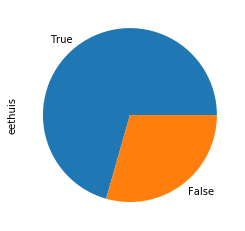

In [14]:
tagEethuis.plot.pie(figsize=(4,4))


#### How many restaurants have the tag "snack"?

In [15]:
tagSnack=df_resto.snack.value_counts()
print(tagSnack)

False    640
True     210
Name: snack, dtype: int64


#### Plot the matching pie chart as before (but for snack)

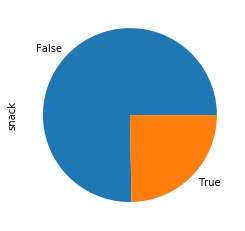

In [16]:
tagSnack.plot.pie(figsize=(4,4))

#### How many restaurant have the tag "cateraar"?

In [17]:
tagCateraar=df_resto.cateraar.value_counts()
print(tagCateraar)

False    743
True     107
Name: cateraar, dtype: int64


#### Plot the matching pie chart as before

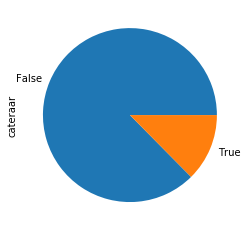

In [18]:
tagCateraar.plot.pie(figsize=(4,4))

#### How many restaurants are both "eethuis" and "cateraar"?
> HINT: You can use boolean indexes similar to as in python. In pandas you can for example do this: df[df.A>3]

In [19]:

print(df_resto[(df_resto.cateraar==True) & (df_resto.eethuis==True)].count())

100-plantaardig     38
100-vegetarisch     38
approved-by-eva     38
cateraar            38
city                38
eethuis             38
eva-voordeel        38
gastronomisch       38
name                38
snack               38
street              38
veganvriendelijk    38
zipcode             38
dtype: int64


#### How many restaurants are both "eethuis" and "snack"?

In [20]:
print(df_resto[(df_resto.snack==True) & (df_resto.eethuis==True)].count())

100-plantaardig     85
100-vegetarisch     85
approved-by-eva     85
cateraar            85
city                85
eethuis             85
eva-voordeel        85
gastronomisch       85
name                85
snack               85
street              85
veganvriendelijk    85
zipcode             85
dtype: int64


#### How many restaurants have the tags "eethuis", "snack" and "cateraar"?

In [21]:
print(df_resto[(df_resto.cateraar==True) & (df_resto.eethuis==True) & (df_resto.snack==True)].count())

100-plantaardig     9
100-vegetarisch     9
approved-by-eva     9
cateraar            9
city                9
eethuis             9
eva-voordeel        9
gastronomisch       9
name                9
snack               9
street              9
veganvriendelijk    9
zipcode             9
dtype: int64


***

#### Next, we want to know more about where these restaurants are located.

> Use the pandas [.apply()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.apply.html) function to execute a function on each row of the dataframe. 

>The function will have the parameter row and using this parameter we will construct a proper address for each restaurant

> The address will then be provided to a web API located at http://loc.geopunt.be/v2/Location 

> This API will return information about the address if possible. The response also contains the latitude and longitude which we need. Add two new fields to the row for the latitude and longitude and assign the received values to it.


In [22]:
def get_coordinates(row):
    # Construct the address
    address = row.street+" "+str(row.zipcode)+" "+row.city
    
    # Create the content of the querystring
    payload = {'q': address}
    
    # URL of the api to request
    api = "http://loc.geopunt.be/v2/Location"
    
    # Execute the request (the response will be in json)
    r = requests.get(api,params=payload)
    
    
    if r.ok:
        try:
            #From r (the response), get the values for the latitude and longitude
            rjson=r.json()
            row['lat'] = rjson['LocationResult'][0]['Location']['Lat_WGS84']
            row['lng'] = rjson['LocationResult'][0]['Location']['Lon_WGS84']
        except:
            print("Could not be found, discarding: " + r.url)
    else:
        row['lat'],row['lng']=np.NaN
    return row
    

In [23]:
# Apply the function created above on every row of the DataFrame
df_resto = df_resto.apply(get_coordinates, axis=1)

Could not be found, discarding: http://loc.geopunt.be/v2/Location?q=E.+Jacqmainlaan+56+1000+Brussel
Could not be found, discarding: http://loc.geopunt.be/v2/Location?q=Leeuwestraat+23+2000+Antwerpen
Could not be found, discarding: http://loc.geopunt.be/v2/Location?q=E.+Jacqmainlaan+7+1000+Brussel
Could not be found, discarding: http://loc.geopunt.be/v2/Location?q=Sint-Amandsstraat+15+9000+Gent
Could not be found, discarding: http://loc.geopunt.be/v2/Location?q=Dikstraat+3+2430+Vorst%2C+Kempen
Could not be found, discarding: http://loc.geopunt.be/v2/Location?q=Dorpstraat+30+9667+Sint-Maria-Horebeke
Could not be found, discarding: http://loc.geopunt.be/v2/Location?q=Alfonssmetsplein+3000+Leuven
Could not be found, discarding: http://loc.geopunt.be/v2/Location?q=Kapucijnestraat+44+8400+Oostende
Could not be found, discarding: http://loc.geopunt.be/v2/Location?q=Borgvalstraat+11+1000+Brussel
Could not be found, discarding: http://loc.geopunt.be/v2/Location?q=Louisalaan+455+1050+Elsene
Coul

Could not be found, discarding: http://loc.geopunt.be/v2/Location?q=Calle+Timanfaya+2+35510+Puerto+del+Carmen+T%C3%ADas%2C+Canarias%2C+Spain
Could not be found, discarding: http://loc.geopunt.be/v2/Location?q=Breughelstraat+32+2000+Antwerpen
Could not be found, discarding: http://loc.geopunt.be/v2/Location?q=Foodmaker+Headoffice+Nijverheidsstraat+56+2260+Westerlo
Could not be found, discarding: http://loc.geopunt.be/v2/Location?q=J.P.+Minckelersstraat+48+3000+Leuven
Could not be found, discarding: http://loc.geopunt.be/v2/Location?q=Paalstraat+2015+2900+Schoten
Could not be found, discarding: http://loc.geopunt.be/v2/Location?q=Minderbroerdersrui+34+2000+Antwerpen
Could not be found, discarding: http://loc.geopunt.be/v2/Location?q=Petite+Somme+5+6940+Septon+Durbuy
Could not be found, discarding: http://loc.geopunt.be/v2/Location?q=Sint-Gillisplein+28+1000+Brussel
Could not be found, discarding: http://loc.geopunt.be/v2/Location?q=Verschansingsstraat+59+2000+Antwerpen


#### How many restaurants are still available in our DataFrame?

In [24]:

df_resto_with_location = df_resto.dropna(subset=['lat','lng'])
print(df_resto_with_location.count())


100-plantaardig     760
100-vegetarisch     760
approved-by-eva     760
cateraar            760
city                760
eethuis             760
eva-voordeel        760
gastronomisch       760
lat                 760
lng                 760
name                760
snack               760
street              760
veganvriendelijk    760
zipcode             760
dtype: int64


#### Next, we will plot the locations of the restaurants in a scatterplot using [matplotlib](https://matplotlib.org/). 
> Matplotlib is a plotting library in python. It contains many plotting options. 

> Use a [scatter plot](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter) to plot the longitude versus latitude (i.e. x-axis = longitude)
> Label the axis, and color the points green.

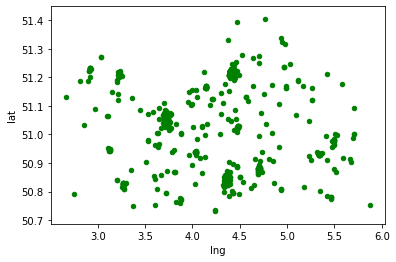

In [25]:

df_resto.plot.scatter(x='lng', y='lat',c='Green')

#### As we don't have an explicit map of Belgium in our scatterplot, it is difficult to distinguish between the different provinces and also cities. Next, we will add the provinces to our DataFrame.

> Use the pandas [.apply()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.apply.html) function to execute a function on each row of the dataframe. Create a function that takes a row of data (a restaurant) and using the zipcode, add an additional field to the row called "provincie" with the matching province value. Subsequently, return the row. To know which range of zipcodes match a certain province use this page: https://nl.wikipedia.org/wiki/Postcode 

In [26]:
def postcodes(row):
    
    try:
            x=int(row.zipcode)
            if x<1300:
                row['provincie']='Brussels Hoofdstedelijk Gewest'
            elif x>1299 and x<1500:
                row['provincie']='Waals-Brabant'
            elif (x>1499 and x<2000) or (x>2999 and x<3500):
                row['provincie']='Vlaams-Brabant'
            elif (x>1999 and x<3000):
                row['provincie']='Antwerpen'
            elif (x>2499 and x<4000):
                row['provincie']='Limburg'
            elif (x>3999 and x<5000):
                row['provincie']='Luik'
            elif (x>4999 and x<6000):
                row['provincie']='Namen'
            elif (x>5999 and x<6600) or (x>6999 and x<8000):
                row['provincie']='Henegouwen'
            elif (x>6599 and x<7000):
                row['provincie']='Luxemburg'
            elif (x>7999 and x<9000):
                row['provincie']='West-Vlaanderen'
            elif (x>8999 and x<10000):
                row['provincie']='Oost-Vlaanderen'
    except:
            print('incorrect zipcode: ' + row.zipcode)
   
    
    return row


> Execute the function using the .apply() method

In [27]:
df_resto = df_resto.apply(postcodes, axis=1)

incorrect zipcode: 35510 Puerto del Carmen


#### Again, plot the coordinates of the restaurants using a scatter plot. However, only plot those that are located in West-Flanders

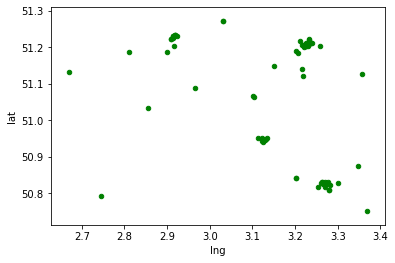

In [28]:

df_resto[(df_resto.provincie=='West-Vlaanderen')].plot.scatter(x='lng', y='lat',c='Green')

#### Plot all the restaurants of flemish provinces on a scatter plot. Plot each point according to its province. I.e. West-Vlaanderen = green; Oost-Vlaanderen = Blue; ...

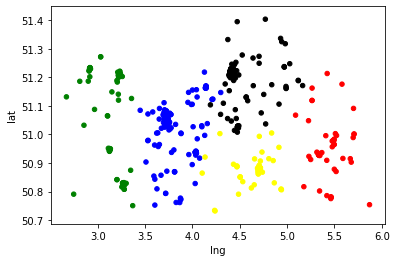

In [29]:
colors ={'West-Vlaanderen':'Green','Oost-Vlaanderen':'blue', 'Limburg':'red', 'Antwerpen':'black','Vlaams-Brabant':'yellow'}
vlaanderen=['West-Vlaanderen','Oost-Vlaanderen','Limburg','Antwerpen','Vlaams-Brabant']
#print(df_resto[df_resto['provincie'].isin(vlaanderen)])
df_resto[df_resto['provincie'].isin(vlaanderen)].plot.scatter(x='lng', y='lat',c=df_resto[df_resto['provincie'].isin(vlaanderen)]['provincie'].apply(lambda x: colors[x]))

> In this map you should see the provinces better. However, it is difficult to see where the most restaurants are located.
> To improve this, we will use a [hexbin](http://pandas.pydata.org/pandas-docs/stable/visualization.html#visualization-hexbin). Pandas also provides some plotting options (it also uses matplotlib in the background). 

#### Use the hexbin plot to plot the location density. No colors have to be assigned to the respective provinces. We only want to know the density. ####

> Set the gridsize equal to 50


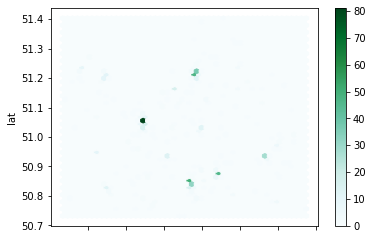

In [30]:
df_resto.plot.hexbin(x='lng', y='lat', gridsize=50)

What area has the highest population of vegetarian restaurants?

In [31]:

(df_resto.groupby(['provincie']))['100-vegetarisch'].value_counts(ascending=True)

provincie                       100-vegetarisch
Antwerpen                       True                17
                                False              163
Brussels Hoofdstedelijk Gewest  True                13
                                False              125
Limburg                         True                 4
                                False               79
Luik                            False                1
                                True                 1
Luxemburg                       False                3
Namen                           False                1
Oost-Vlaanderen                 True                20
                                False              229
Vlaams-Brabant                  True                 8
                                False               86
West-Vlaanderen                 True                 6
                                False               93
Name: 100-vegetarisch, dtype: int64

#### Plot a pie chart wherein every piece of the chart illustrates how many restaurants (percentage) there are in the respective provinces

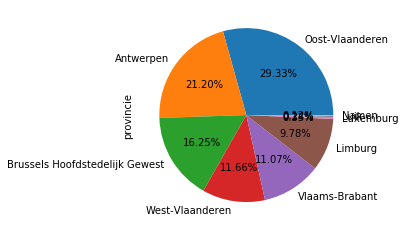

In [32]:
df_prov=df_resto.provincie.value_counts()


df_prov.plot.pie(figsize=(4,4),autopct='%.2f%%')

##### Which provence has the most restaurants? 
> Do not use the value you can read from the pie chart. Use the value_counts function and the argmax function on the DataFrame

In [33]:
df_resto.provincie.value_counts().idxmax()

'Oost-Vlaanderen'

#### Plot a pie chart for the provence you found in the previous question. The piechart should contain three pieces, i.e. snack, eethuis and cateraar


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001953CAD1DA0>],
      dtype=object)

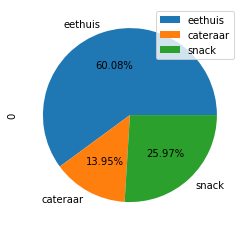

In [34]:

df2 = pd.DataFrame(df_resto.groupby('provincie').get_group('Oost-Vlaanderen').sum(), index=['eethuis', 'cateraar', 'snack'])
df2.plot.pie(figsize=(4,4),autopct='%.2f%%', subplots=True)

#### Create a stacked bardiagram. Each bar should correspond to a provence. Each segment in the bar should correspond to eethuis, snack or catraar. The pieces should represent how many restaurants in the respective province have the respective tag.

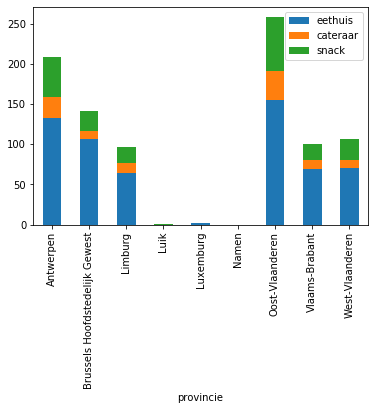

In [35]:

df3 = pd.DataFrame(df_resto.groupby(['provincie']).sum(), columns=['eethuis', 'cateraar', 'snack'])
df3.plot(kind='bar', stacked=True)

***

### Next, we will look at the other tags a restaurant can have

#### How many restaurants have the tag gastronomisch?

In [36]:
tagGastronomisch=df_resto.gastronomisch.value_counts()
print(tagGastronomisch)

False    812
True      38
Name: gastronomisch, dtype: int64


#### In which unique provinces are these restaurants located? And how many are there per province? Show this in a bar chart.

In [37]:
df3 = pd.DataFrame(df_resto.groupby(['provincie']).sum(), columns=['gastronomisch'])
df3


,gastronomisch
provincie,
Antwerpen,4.0
Brussels Hoofdstedelijk Gewest,4.0
Limburg,11.0
Luik,1.0
Luxemburg,0.0
Namen,1.0
Oost-Vlaanderen,11.0
Vlaams-Brabant,1.0
West-Vlaanderen,5.0


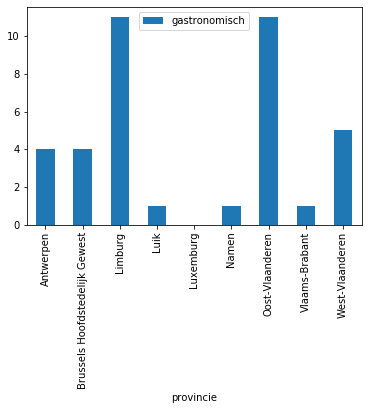

In [38]:

df3.plot(kind='bar', stacked=True)

***

#### How many restaurants are there with 5 tags, how many with 4 tags, etc ... plot this is a bar diagram (tags are the columns with boolean values)

In [39]:
def count_tags(row):
    # Count how many tags there are in the row
    try:
        count=0
        for val in row:
            if val==True:
                count= count+1
        row['nr_of_tags']=count
    except:
        row['nr_of_tags']=0
        
    return row

In [40]:
#Apply the above function on the DataFrame
df_resto = df_resto.apply(count_tags, axis=1)


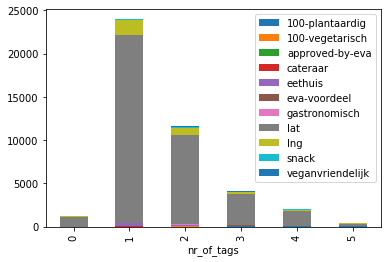

In [41]:
#Plot

df_resto.groupby(['nr_of_tags']).sum().plot(kind='bar', stacked=True)

#### Create a scatter plot of the locations of the restaurants (longitude versus latitude), where the size of the points is equal to number of tags to the power of three

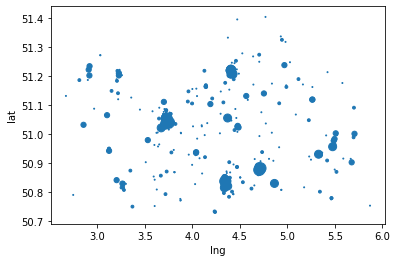

In [42]:
size= np.power(df_resto['nr_of_tags'],3)
df_resto.plot.scatter(x='lng', y='lat', s=size)

#### Create a pie chart plot for each individual provence. Each pie chart should illustrate how many restaurants have how many tags (in percentage)

> HINT: this can be done using one single command by chaining several methods

> HINT: plotting can be done using subplots

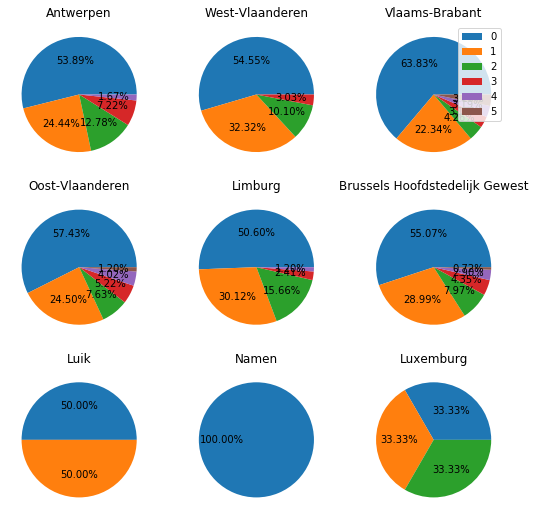

In [43]:
df5=df_resto.groupby(['provincie'])['nr_of_tags'].value_counts()

fig, axs = plt.subplots(3, 3,figsize=(9,9))
labels='0','1','2','3','4','5'
axs[0, 1].pie(df5['West-Vlaanderen'],autopct='%.2f%%')
axs[0, 1].set_title('West-Vlaanderen')

axs[1,0].pie(df5['Oost-Vlaanderen'],autopct='%.2f%%')
axs[1,0].set_title('Oost-Vlaanderen')

axs[1,1].pie(df5['Limburg'],autopct='%.2f%%')
axs[1,1].set_title('Limburg')

axs[0,0].pie(df5['Antwerpen'],autopct='%.2f%%')
axs[0,0].set_title('Antwerpen')

axs[0,2].pie(df5['Vlaams-Brabant'],autopct='%.2f%%')
axs[0,2].set_title('Vlaams-Brabant')

axs[1,2].pie(df5['Brussels Hoofdstedelijk Gewest'],autopct='%.2f%%')
axs[1,2].set_title('Brussels Hoofdstedelijk Gewest')

axs[2,0].pie(df5['Luik'],autopct='%.2f%%')
axs[2,0].set_title('Luik')

axs[2,1].pie(df5['Namen'],autopct='%.2f%%')
axs[2,1].set_title('Namen')

axs[2,2].pie(df5['Luxemburg'],autopct='%.2f%%')
axs[2,2].set_title('Luxemburg')
axs[0,2].legend(labels=labels, loc="upper right")


#### Which cities have one or more restaurants with 4 tags?

In [44]:
df6=df_resto[df_resto['nr_of_tags']>=4]['city']

In [45]:
print(df6.unique())

['Gent' 'Gentbrugge' 'Ledeberg' 'Sint - Gillis' 'Baal' 'Leuven'
 'Antwerpen' 'Brussel (Elsene)' 'Hasselt' 'Genk' 'Vorst' 'Brussel'
 'Boutersem' 'Kessel-Lo' 'Willebroek' 'Sint-Denijs-Westrem']


## Part 2: Clustering

You can work together with a colleague for this part. This part introduces techniques to cluster similar kind of data. Clustering is called an unsupervised machine learning technique since there is no truth value for the samples under consideration. It can be applied to any (telecommunications, textual, social media and multimedia) sort of data. In this lab session we'll learn how to perform basic clustering and then apply the same techniques to a compress an image.

In this exercise we'll perform a particular type of clustering known as k-means clustering. We'll start with a simple 2D example to help you understand how k-means algorithm works. After this we'll use k-means algorithm to compress an image by reducing the number of colors to only the most common one in the image. The image data is non-trivial in the sense that it is 3D data. Thus the intuition gained in the experiment with 2D data will help us with the 3D data.

The cell below defines a helper function to load the dataset from a file into program memory.

In [3]:
def load_dataset(file_name):      #general function to parse tab -delimited floats
    data_mat = []                #assume last column is target value
    fr = open(file_name)
    for line in fr.readlines():
        cur_line = line.strip().split('\t')
        flat_line = list(map(float,cur_line)) #map all elements to float()
        data_mat.append(flat_line)
    return data_mat

Load the dataset:

In [4]:
data_list = load_dataset('./testSet.txt')

Import the numpy library for python. Numpy supports a vast array of numerical manipulations and is best suited for developing machine learning algorithms.

There are libraries like scikit-learn for python which provide a large number of machine learning algorithms. However for this tutorial since we'll implement the k-Means clustering algorithm ourselves, numpy fits our case very well.

Numpy works with ndarrays. It a datatype best suited for numerical calculations. Thus we convert our list of data into a numpy array. 

You can read more about numpy array's here: https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.ndarray.html

In [5]:
data_mat = np.array(data_list, dtype=np.float64)

Since, data_mat is an array now, find out about the size of it. How many samples and variables do we have and what are the dimensions of this array?

In [6]:
print(type(data_mat))
print(data_mat.size)
print(data_mat.itemsize)
print(data_mat.shape)
print(data_mat.ndim)

<class 'numpy.ndarray'>
160
8
(80, 2)
2


#### Let's visualize the data
To visualize the data, we'll draw a scatter plot for the data.

<IPython.core.display.Javascript object>


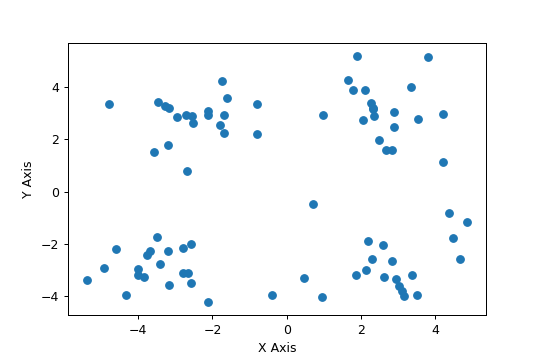

In [7]:
# provides the interactivity on the images by loading the plot as a javascript object.

%matplotlib nbagg

import matplotlib.pyplot as plt


fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(data_mat[:, 0], data_mat[:, 1])
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')

plt.show()

###### Please switch off the interactivity of the previous graph before moving forward.

## k-Means Clustering

For a given x number of samples, k-Means algorithm assigns them to k number of clusters. The algorithm is an iterative procedure. It starts by randomly creating k centroids. Centroids are considered the "centers" of the k clusters. 

> Then it assigns all of the x samples to the k centroids. 

> After this it recalculates the centroids by calculating the average of the samples assigned to each of the k centroids.

The algorithm always converges. However this convergence depends on the intial random choice of centroids and thus the converged solution may not always be optimal.

[//]: # "The above two steps are repeated untill a stopping criteria. For simplification purposes we'll put a hard limit on the number of iterations for the two above steps."

In the next steps, we'll define functions that cater to the different objectives mentioned above.

### Initializing random centroids

There are many different ways to initiate the centroids. A straighforward one is to randomly choose the requested number of centroids from the provided data.

The function below satisfies that goal.

In [8]:
import random
from random import shuffle
random.seed(9000)

In [9]:
def init_centroids(data_mat, num_centroids):
    """

    :param data_mat:
    :param num_centroids:
    :return:
    """

    shape_data_mat = data_mat.shape
    centroids = np.zeros((num_centroids, shape_data_mat[1]))
    # print(centroids)
    ids = [x for x in range(shape_data_mat[0])]
    shuffle(ids)
    centroids = data_mat[ids[:num_centroids], :]

    return centroids

Let's compute the initial set of 4 centroids for our dataset.

Why four?

Please fill in the answer below:

###### In het scatterplot kunnen we zien dat er vier grote groepen zijn. Kan ook bepaald worden door de euclidische afstand.

Alos write the correct function call in the code below.

In [10]:
primary_centroids = init_centroids(data_mat, 4)

In [11]:
import pprint
pprint.pprint(primary_centroids)

array([[ 1.658985,  4.285136],
       [-0.39237 , -3.963704],
       [-3.195883, -2.283926],
       [-0.790153,  3.343144]])


###### Are these centoids assigned properly?

The next step is to assign our 80 samples to these 4 centroids thus creating 4 clusters. To this purpose, let's define the function to assign samples of a dataset to a set of centroids. Note that the dataset and centroids must have same dimensions.

The function defined below does that. It takes in the data matrix and the centroids and returns another numpy array containing the centroid id assignment (cluster number) for each sample.

In [12]:
def assign_centroid(data_mat, centroids):
    """
    <docstring>
    :param data_mat: the data matrix
    :param centroids: the centroids
    :return: a numpy array that assigns a centroid id to each sample
    """

    num_centroids = centroids.size-4
    shape_data_mat = data_mat.shape

    idx = np.zeros((shape_data_mat[0], 1))
   
    
    # for each sample in the data
    for sample_index in range(idx.shape[0]):
        sample = data_mat[sample_index]

        least_dist = float('inf')
        
        # for each centroid
        for centroid_id in range(num_centroids):
            
            centroid = centroids[centroid_id]
            # get the euclidean distance between the centroid and sample
            dist = np.sqrt(np.power(centroid[0]-sample[0],2)+np.power(centroid[1]-sample[1],2))
            
            #Assign the centroid to the sample if it is the closest one
            if(dist<least_dist):
                least_dist=dist
                idx[sample_index] = centroid_id

    return idx

In [13]:
idx_sample = assign_centroid(data_mat, primary_centroids)

Let's see the assignment to each sample in the data.

In [14]:
print(idx_sample)

[[0.]
 [3.]
 [1.]
 [2.]
 [0.]
 [3.]
 [1.]
 [2.]
 [0.]
 [3.]
 [1.]
 [2.]
 [0.]
 [3.]
 [1.]
 [1.]
 [0.]
 [3.]
 [1.]
 [2.]
 [0.]
 [3.]
 [1.]
 [2.]
 [0.]
 [3.]
 [1.]
 [2.]
 [0.]
 [2.]
 [1.]
 [2.]
 [0.]
 [3.]
 [1.]
 [2.]
 [0.]
 [3.]
 [1.]
 [2.]
 [0.]
 [3.]
 [1.]
 [1.]
 [0.]
 [3.]
 [1.]
 [2.]
 [0.]
 [3.]
 [1.]
 [2.]
 [0.]
 [3.]
 [1.]
 [2.]
 [0.]
 [3.]
 [1.]
 [2.]
 [0.]
 [3.]
 [1.]
 [2.]
 [0.]
 [3.]
 [1.]
 [2.]
 [0.]
 [3.]
 [1.]
 [2.]
 [0.]
 [3.]
 [1.]
 [2.]
 [0.]
 [3.]
 [1.]
 [2.]]


The next step of the process is to recompute the centroids from this assignment. The centroids are computed as the average of the samples of the current cluster for each centroid.

The centroids are computed as the average of the samples that currently belong to the cluster for each centroid. This provides us with the next set of centroids.

The function defined below achieves that goal.

In [15]:
def compute_centroids(data_mat, sample_idx, num_centroids):
    """

    :param data_mat:
    :param sample_idx:
    :param num_centroids:
    :return: The new centroids by computing the means of the samples assigned to each centroid
    """

    shape_data_mat = data_mat.shape
    centroids = np.zeros((num_centroids, shape_data_mat[1]))

    for centroid_id in range(num_centroids):
        sample_indices = np.where(sample_idx == centroid_id) # np.where always return a tuple where the first element is the array of indices
        centroids[centroid_id, :] = np.true_divide(np.sum(data_mat[sample_indices[0], :], axis=0), len(sample_indices[0]))

    return centroids

Let's print the new centroids and see if they are different from the old ones or not. :D

In [16]:
centroids_sample = compute_centroids(data_mat, idx_sample, 4)
pprint.pprint(centroids_sample)

array([[ 2.6265299 ,  3.10868015],
       [ 2.43385309, -2.85575373],
       [-3.56908268, -2.62975353],
       [-2.45009747,  2.89275747]])


Do they change or not?

In the following step we put together the two functions defined above to define the k-Means algorithm as described in the beginning of the exercise.

Please ``<fill in>`` the correct code. 

In [17]:
def kmeans(data_mat, prim_centroids, max_iterations, plot_iterations=False):
    """
    <docstring>
    :param data_mat: the data matrix
    :param prim_centroids: centroids
    :param max_iterations: maximum number of iterations
    :plot_iterations: Boolean variable which controls whether to plot the cluster assignments on each oteration or not. Works only for 2D data.
    :return: numpy array of the final centroids and another numpy array containig the cluster id for each sample.
    """

    shape_prim_centroids = prim_centroids.shape
    shape_data_mat = data_mat.shape
    num_centroids = shape_prim_centroids[0]
    centroids = prim_centroids
    idx = np.zeros((shape_data_mat[0], 1))
    
    fig = plt.figure()
    ax = fig.add_subplot(111)

    for i in range(max_iterations):
        print('kmeans iteration ', i+1, 'of', max_iterations)
        
        idx=assign_centroid(data_mat, centroids)
        centroids=compute_centroids(data_mat, idx, num_centroids)
        
        # plot progress
        if plot_iterations:
            ax.scatter(data_mat[:, 0], data_mat[:, 1], c = idx.flatten())
            ax.scatter(centroids[:,0], centroids[:,1], marker='+', s=100)
            fig.canvas.draw()
            var_continue = input('Press enter to continue.')
            plt.cla()
#         print('Centroids are: ', centroids)

    return centroids, idx

In [18]:
maximux_iterations = 5

<IPython.core.display.Javascript object>


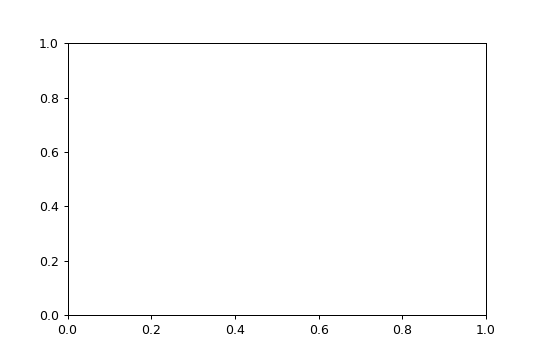

kmeans iteration  1 of 5
Press enter to continue.
kmeans iteration  2 of 5
Press enter to continue.
kmeans iteration  3 of 5
Press enter to continue.
kmeans iteration  4 of 5
Press enter to continue.
kmeans iteration  5 of 5
Press enter to continue.


In [19]:
centroids, idx = kmeans(data_mat, primary_centroids, maximux_iterations, plot_iterations=True)

Notice something interesting about the plot/output? How come?

Now, Lets visualize the final locations of these clusters.<br>
Give the points of each cluster a different color.

<IPython.core.display.Javascript object>


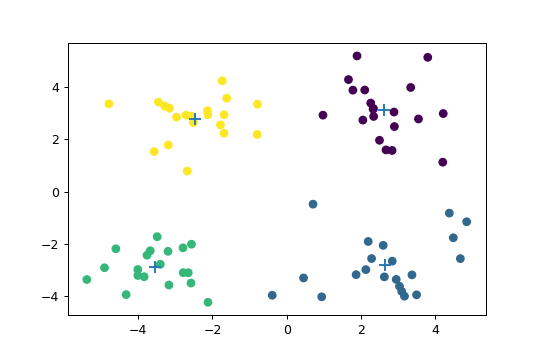

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data_mat[:, 0], data_mat[:, 1], c = idx.flatten())
ax.scatter(centroids[:,0], centroids[:,1], marker='+', s=100)
plt.show()

## Material You Need to Submit
For this lab session, the notebooks with all source code, optional extra files need to be handed in using Ufora. Zip or rar your notebook and files and name the archive: 2019-2020_Lab1_Name.zip/.rar. The lab files needs to be uploaded before the start of the next lab session. Make sure all your notebooks are already executed when you upload them (i.e. there should be output after the cells). 

The end